In [1]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
from ipywidgets import widgets
import ConfigReader as cr

In [2]:
idx = pd.IndexSlice

#Styles
sns.set_style('darkgrid')
sns.set_color_codes()
plt.rcParams['figure.figsize'] = (12.0, 9.0)

plt.rc('text', usetex=False)
plt.rc('font', size=20.0, family='serif')

In [7]:
# Data location and scenario
data_dir = '../../Experiments_results/autonet_0305_benchmark/results/experiment'
dataset = '917_bac'
preprocessor='NoPreprocessing'
fline = 'validationResults-detailed-traj-run-30-walltime.csv'
traj_file = os.path.join(data_dir, dataset, preprocessor, dataset, fline)

In [8]:
reader = cr.ConfigReader(data_dir=data_dir, dataset=dataset)
tdf = reader.load_validation_trajectories(preprocessor=preprocessor, load_config=True)

In [9]:
tdf.loc[:, ('classifier','num_layers')] = tdf['classifier']['num_layers'].apply(lambda X:ord(X)-ord('a'))

In [10]:
# Start filtering the error
temp_df = tdf.copy()
temp_df.columns = tdf.columns.droplevel(0)

In [11]:
min_perf = temp_df['test_performance'].min()
mean_perf = temp_df['test_performance'].mean()
std_perf = temp_df['test_performance'].std()

In [20]:
m = tdf[('smac', 'test_performance')] <= mean_perf
#tdf[m]

### Setting values to log scale and categorical values

In [12]:
log_columns = ['beta1', 'beta2', 'gamma', 'lambda2', 'learning_rate', 'momentum','num_units_layer_1',
               'num_units_layer_2', 'num_units_layer_3', 'num_units_layer_4', 'num_units_layer_5',
               'num_units_layer_6', 'power', 'std_layer_1', 'std_layer_2', 'std_layer_3','std_layer_4',
               'std_layer_5', 'std_layer_6']

categorical_cols = ['activation_layer_1', 'activation_layer_2', 'activation_layer_3', 'activation_layer_4',
                    'activation_layer_5', 'activation_layer_6', 'lr_policy', 'num_layers', 'weight_init_1',
                    'weight_init_2', 'weight_init_3', 'weight_init_4', 'weight_init_5', 'weight_init_6']

In [13]:
for lc in log_columns:
    try:
        tdf.loc[:, ('classifier', lc)] = np.log10(tdf.loc[:, ('classifier', lc)])
    except KeyError:
        continue

In [14]:
for cc in categorical_cols:
    try:
        tdf.loc[:, ('classifier',cc)] = tdf.loc[:, ('classifier',cc)].astype('category')
    except KeyError:
        continue

## After Setting the frames. Start with the plotting

In [15]:
# Plot the empirical CDF
sorted_train = (tdf.sort_values(by=('smac','train_performance'), ascending=True).loc[:,('smac','train_performance')].values)
sorted_test  = (tdf.sort_values(by=('smac','test_performance'), ascending=True).loc[:,('smac','test_performance')].values)
ytrain = np.arange(len(sorted_train)) / float(len(sorted_train))
ytest = np.arange(len(sorted_test)) / float(len(sorted_test))

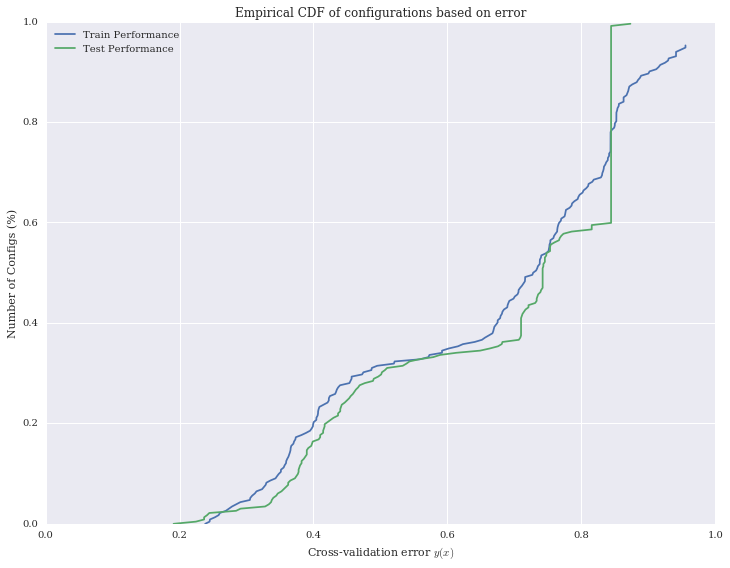

In [16]:
plt.plot(sorted_train, ytrain, label="Train Performance")
plt.plot(sorted_test, ytest, label="Test Performance")
plt.xlabel("Cross-validation error $y(x)$")
plt.ylabel(r"Number of Configs (%)")
plt.xlim(0.0, min(1.0, sorted_train.max()))
plt.title("Empirical CDF of configurations based on error")
plt.legend(loc='best')
plt.show()

In [17]:
def plotting_threshold(error_threshold, categories):
    mask_filter = tdf[('smac','test_performance')] <= error_threshold
    filtered = tdf[mask_filter]
    fig_f, axs = plt.subplots(ncols=2,nrows=1, figsize=(15.0, 8.5))
    ax0, ax1 = axs.flat
    sns.boxplot(x=categories, y=('smac','test_performance'), data=filtered, ax=ax0)
    sns.countplot(y=categories, data=filtered, ax=ax1)
    fig_f.tight_layout()

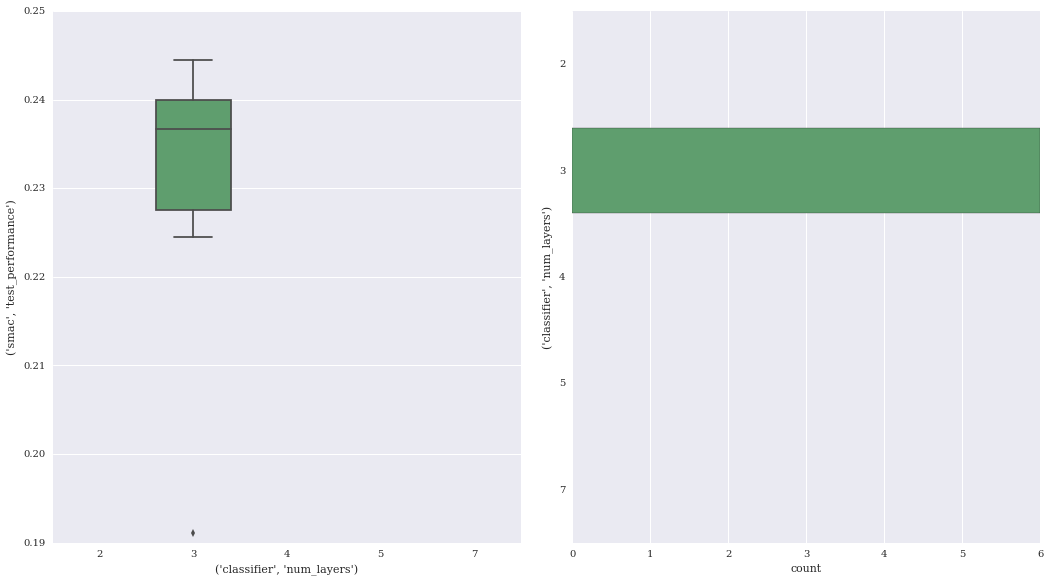

In [18]:
widgets.interact(plotting_threshold, error_threshold=(min_perf,mean_perf + std_perf, 0.01),
                 categories={'Solver':('classifier','solver'), 'Policy':('classifier','lr_policy'),
                             'Number of layers':('classifier','num_layers')})

### Plot distro over learning rates

In [21]:
# Create the grouping of the filtered DF
classifier_df = tdf[m]['classifier']
solver_filt = classifier_df.groupby('solver')

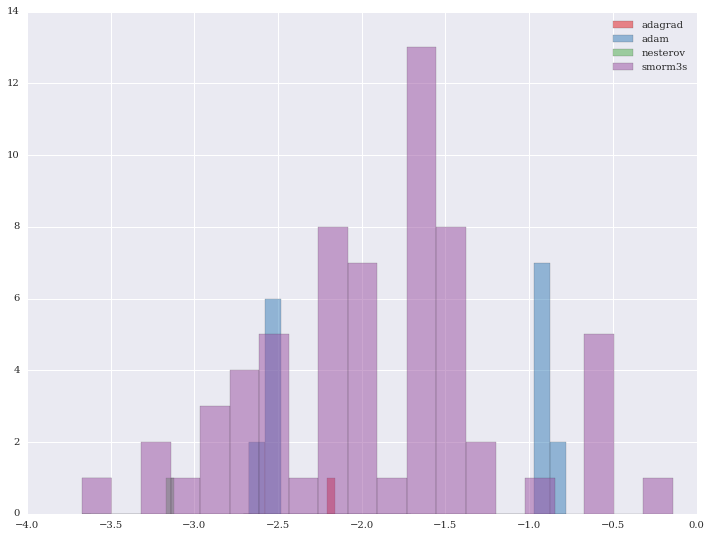

In [25]:
# Seaborns Normed Distribution plots
with sns.color_palette('Set1',8):
    for name,groups in solver_filt:
        #sns.distplot(groups.learning_rate, bins=6, kde_kws={'label':name, 'bw':0.019})
        #sns.distplot(groups.learning_rate, kde=False, bins=10, hist_kws={'label':name}, norm_hist=False)
        plt.hist(groups.learning_rate.values, alpha=0.5, bins=20, label=name)
    plt.legend()

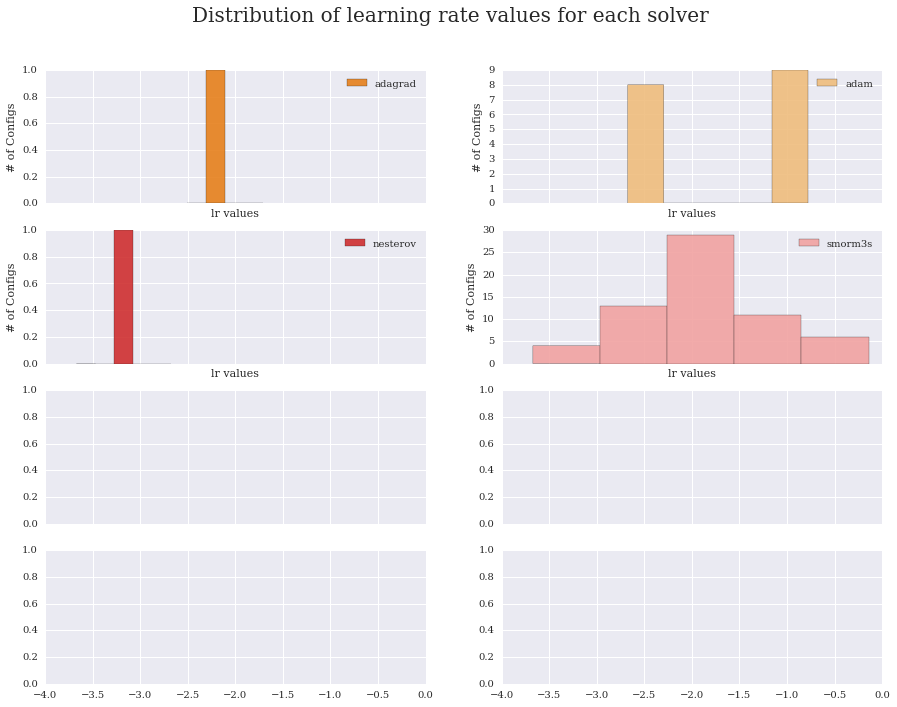

In [28]:
col_hist = sns.color_palette('Paired',8, desat=0.8)
fig2, axs = plt.subplots(nrows=4, ncols=2, sharex=True, figsize=(15.,11.))
fig2.suptitle('Distribution of learning rate values for each solver')
for ax, (name, groups) in zip(axs.flat,solver_filt):
    ax.hist(groups.learning_rate.values, bins=5, histtype='bar', fill=True,
            label=name, alpha=0.9, color=col_hist.pop())
    ax.set_xlabel('lr values')
    ax.set_ylabel('# of Configs')
    ax.legend()
#plt.tight_layout()
#ax = axs.flat[-1]
#ax.set_visible(False)

### Plot over different preprocessing methods

In [29]:
# Create the grouping of the filtered DF
prepro_filt = tdf[m].groupby([('preprocessor','choice')])

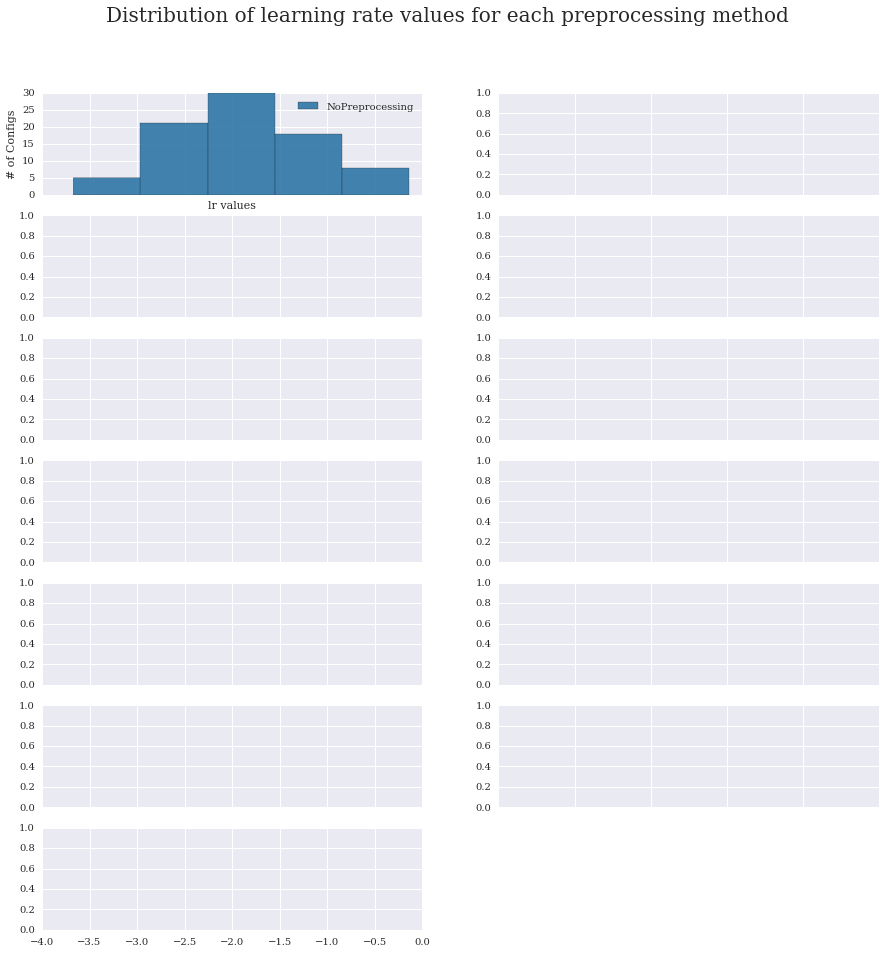

In [30]:
prepro_color = sns.color_palette('Paired',14, desat=0.8)

fig4, axs = plt.subplots(nrows=7, ncols=2, sharex='col', figsize=(15.,15.))
fig4.suptitle('Distribution of learning rate values for each preprocessing method')
for ax, (name, grops) in zip(axs.flat,prepro_filt):
    groups = grops['classifier']
    ax.hist(groups.learning_rate.values, bins=5, histtype='bar', fill=True, label=name,
            alpha=0.9, color=prepro_color.pop())
    ax.set_xlabel('lr values')
    ax.set_ylabel('# of Configs')
    ax.legend()
ax = axs.flat[-1]
ax.set_visible(False)

### Plot over different solver

In [31]:
def histogram_group_column_plotting(grouping, column):
    g = classifier_df.groupby(grouping)
    s = len(g)
    col_hist = sns.color_palette('Paired',s, desat=0.8)
    fig_hist, axs = plt.subplots(nrows=int(np.ceil(s/2.)), ncols=2, sharex='col',
                                 figsize=(15., 11.))
    for ax, (name, groups) in zip(axs.flat, g):
        ax.hist(groups[column].dropna().values, bins=15,
                histtype='bar', fill=True, label=name, alpha=0.9, color=col_hist.pop())
        ax.set_xlabel(column + ' values')
        ax.set_ylabel('# of Configs')
        ax.legend()
    ax = axs.flat[7]
    ax.set_visible(False)
    fig_hist.suptitle('Distribution of '+ column +' values for each '+(grouping))

In [32]:
# Create columns dict
Groups = ['solver', 'lr_policy']
Plott = {'# of Epochs':'number_updates', 'batch size':'batch_size',
         'step (lr_policy)':'epoch_step', 'Gamma':'gamma', 'Lambda':'lambda2', 'learning rate': 'learning_rate',
         'Beta 1':'beta1', 'Beta 2':'beta2', 'Momentum':'momentum', 'Rho':'rho', 'Power':'power',
         'Dropout rate of layer 1':'dropout_layer_1', 'Dropout rate of layer 2':'dropout_layer_2',
         'Dropout rate of layer 3':'dropout_layer_3', 'Dropout rate of layer 4':'dropout_layer_4',
         'Dropout rate of layer 5':'dropout_layer_5', 'Dropout rate at output':'dropout_output'}

IndexError: index 7 is out of bounds for axis 0 with size 4

<function __main__.histogram_group_column_plotting>

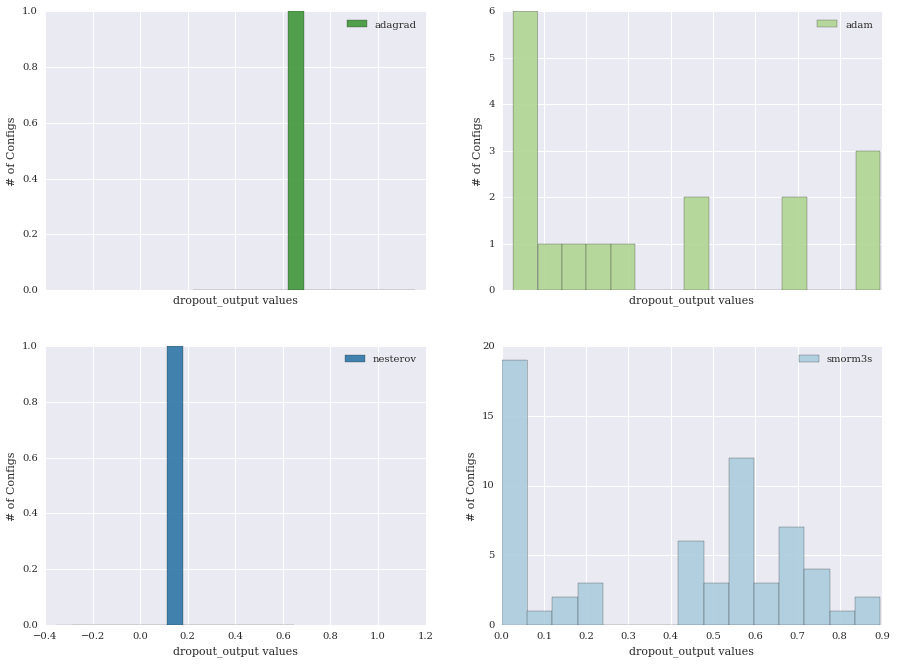

In [33]:
widgets.interact(histogram_group_column_plotting, grouping=Groups, column=Plott)

### Distribution of each parameter over all filtered configurations

In [34]:
def histogram_column_plotting(column):
    #Have to convert the -1 to NaN
    fig_hist = plt.figure(6)
    ax1 = plt.subplot(111)
    ax1.set_title('Histogram of '+column)
    classifier_df[column].plot(kind='hist', bins=15, ax=ax1)
    ax1.set_xlabel('values')

In [35]:
non_cat_cols = [item for item in classifier_df.columns.values if item not in categorical_cols]

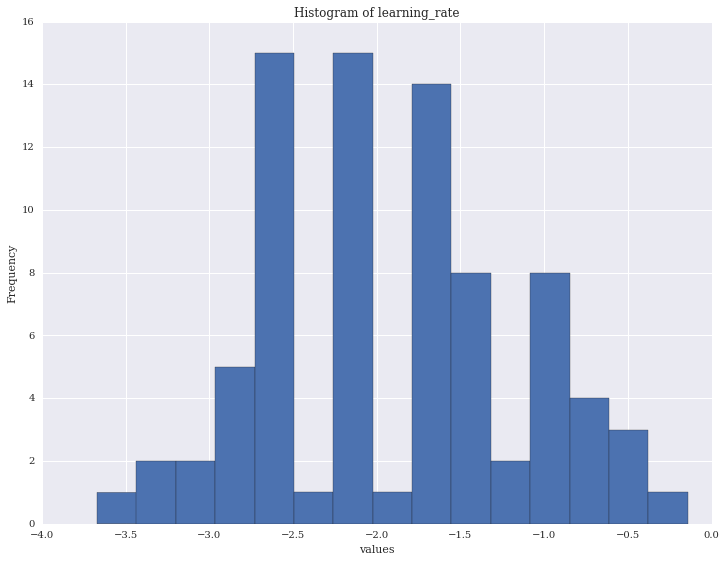

In [36]:
widgets.interact(histogram_column_plotting, column=non_cat_cols)

## Plot average best architectures

In [37]:
top5 = tdf.sort_values([('smac','test_performance')]).head(5)

In [38]:
top5

balancing         classifier                                        \
      strategy activation_layer_1 activation_layer_2 activation_layer_3   
96   weighting         scaledTanh            sigmoid                NaN   
137  weighting                elu            sigmoid                NaN   
166       none               tanh            sigmoid                NaN   
165       none               tanh            sigmoid                NaN   
95   weighting         scaledTanh            sigmoid                NaN   

                                                                               \
    activation_layer_4 activation_layer_5 activation_layer_6 batch_size beta1   
96                 NaN                NaN                NaN         33   NaN   
137                NaN                NaN                NaN         63   NaN   
166                NaN                NaN                NaN         69   NaN   
165                NaN                NaN                NaN         65   NaN   
95                 NaN                NaN                NaN         35   NaN   

                 ...                      imputation one_hot_encoding  \
    beta2        ...        weight_init_6   strategy minimum_fraction   
96    NaN        ...                  NaN     median         0.120188   
137   NaN        ...                  NaN       mean         0.078416   
166   NaN        ...                  NaN     median              NaN   
165   NaN        ...                  NaN       mean              NaN   
95    NaN        ...                  NaN     median         0.120188   

                             preprocessor    rescaling      smac  \
    use_minimum_fraction           choice       choice config_ID   
96                  True  NoPreprocessing  standardize        14   
137                 True  NoPreprocessing    normalize        12   
166                False  NoPreprocessing    normalize        19   
165                False  NoPreprocessing    normalize        18   
95                  True  NoPreprocessing         none        13   

                                                   
    test_performance       time train_performance  
96          0.191111  79316.519          0.252686  
137         0.224444  75788.196          0.244846  
166         0.236667  66015.399          0.238277  
165         0.236667  59124.179          0.260209  
95          0.241111  41861.274          0.258319  

[5 rows x 66 columns]

In [104]:
range(1,lays+1)


[1, 2, 3]

<Container object of 3 artists>

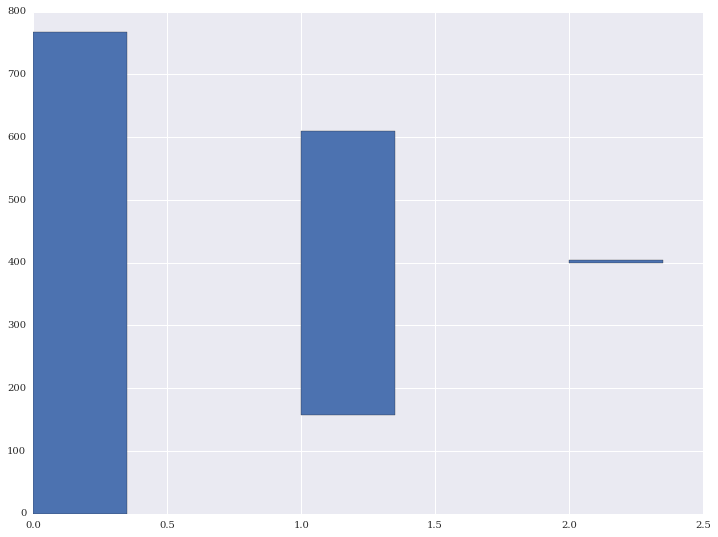

In [122]:
bar_width = 0.35
fig_arch = plt.figure(4, figsize=(12.,9.))
ax_arch = plt.subplot(111)

ax_arch.bar(range(lays), [10**n_1, 10**n_2, 4], bottom=[0, dif_1/2, 400], width=bar_width)

In [120]:
dif_1 = (10**n_1) - (10**n_2)

In [128]:
a = pd.Series([2,5,8,7])

In [189]:
a.values

array([2, 5, 8, 7])

In [231]:
pd.rolling_apply(a, func=lambda x: x[-1]-x[0], window=2, min_periods=1)

0    0
1    3
2    3
3   -1
dtype: float64

In [204]:
pd.rolling_sum(a, 2, 1)

0     2
1     7
2    13
3    15
dtype: float64

In [72]:
lays = np.int(np.array(top5['classifier']['num_layers']).mean())

In [ ]:
activations = []
n_layers = []
weights = []
for i in range(1,lays):
    activations.append(top5['classifier']['activation_layer_'+str(i)].describe().top)
    n_layers.append(top5['classifier']['num_units_layer_'+str(i)].mean())
    weights.append(top5['classifier']['weight_init_1'].describe().top)

In [101]:
pre_m = top5['preprocessor']['choice'].describe().top